In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
from scipy.stats import zscore
import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *
from collect_snmf_isoforms import *

# import rpy2
# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri
# import rpy2.robjects.packages as rpackages

loading modules
some more modules
custom-made modules
finished loading modules


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


In [2]:

def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))


def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


def plot_barh_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.barh(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot_h(EL, samples, color_list, label_list, sort_factor = False, figsize=None, xlim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (N/3,K/1.2)
    
    
    

    if one_row:
        fig, axes = plt.subplots(N+1,2, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.1}, 
                             height_ratios = (([4]*N) + [1]), width_ratios = [1.2, 10])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[j, 1]

            ax_ = axes[j, 0]
            ax_.barh([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[0, 1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([0, loading], [i, i], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([cum_sum, top_bar], [i, i], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([median, median], [len(loadings), 0], linestyle = '--', c='black', linewidth=2)
            ax.scatter([median], [middle_point], marker="D", c = 'black', s=10, zorder=len(loadings)+2)

            axes[N, 1].spines['top'].set_visible(False)
            axes[N, 1].spines['right'].set_visible(False)
            axes[N, 1].spines['left'].set_visible(False)
            axes[N, 1].set_yticks([])
            axes[N,1].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if xlim is None:
                axes[N, 0].set_xlim([0,1])

                ax.set_xlim([0,1])
            else:
                axes[N, 1].set_xlim(xlim)
                ax.set_xlim(xlim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[N, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            
            # ax[0].set_ylabel(factor)
            #plot_bar_ax(loadings, color, ax, label=label, sort_factor=True)

    # axes

    else:
        fig, axes = plt.subplots(K,N+1, figsize=figsize, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                             width_ratios = ([1]+([4]*N)))
    
        for i, factor in enumerate(factors):
            color = color_list[i]
            
            axes[i,0].spines['top'].set_visible(False)
            axes[i,0].spines['right'].set_visible(False)
            axes[i,0].spines['bottom'].set_visible(False)
            axes[i,0].set_xticks([])
            axes[i,0].set_ylabel(factor)
            
            factor_max = EL[factor].max()
            
            axes[i,0].set_ylim([0,factor_max])
            
            for j, tissue in enumerate(tissues):
                if i == (len(factors)-1):
                    label = label_list[j]
                else:
                    label = ''
                tissue_samples = samples.loc[samples.tissue_id == tissue].index
                loadings = list(EL.loc[tissue_samples, factor])
                
                    
                ax = axes[i,j+1]
                plot_barh_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
                
                ax.set_ylim([0,factor_max])
                ax.spines['top'].set_visible(False)
                
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                
    
            #     ax.axis('off')  # Hide
                ax.margins(0, 0)
                
    
                ax.set_xlabel(label, rotation=45)



def plot_bar_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.bar(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot(EL, samples, color_list, label_list, tissue_colors, sort_factor = False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)
    
    
    fig, axes = plt.subplots(K+1,N+1, figsize=(N/3,K/1.5), gridspec_kw={'wspace': 0.1, 'hspace': 0.2}, 
                             width_ratios = ([1]+([4]*N)), height_ratios=[1]*K + [0.25])
    
    for i, factor in enumerate(factors):
        color = color_list[i]
        
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(False)
        axes[i,0].set_xticks([])
        # axes[i,0].set_ylabel(factor)
        
        factor_max = EL[factor].max()
        
        axes[i,0].set_ylim([0,factor_max])
        
        for j, tissue in enumerate(tissues):
            if i == (len(factors)-1):
                label = label_list[j]
            else:
                label = ''
            tissue_samples = samples.loc[samples.tissue_id == tissue].index
            loadings = list(EL.loc[tissue_samples, factor])
            
                
            ax = axes[i,j+1]
            plot_bar_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
            
            ax.set_ylim([0,factor_max])
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            

        #     ax.axis('off')  # Hide
            ax.margins(0, 0)
            

            # ax.set_xlabel(label, rotation=45)


            ax_ = axes[K, j+1]
            ax_.barh([1], [1], color = tissue_colors[j])
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

    
            axes[K, 0].axis('off')  # Hide
            axes[K, 0].margins(0, 0)




In [78]:
def group_matrix(df, k=9):
    # Determine the number of groups
    n_groups = df.shape[1] // k
    
    # Initialize a list to store the results
    output = []
    
    # Split the dataframe into groups of k columns and sum them
    for i in range(n_groups):
        group_start_col = k * i
        group_end_col = min(k * (i + 1), df.shape[1])
        
        group_sum = df.iloc[:, group_start_col:group_end_col].sum(axis=1, skipna=True)
        
        # Create a new DataFrame with one column and set its name
        group_df = pd.DataFrame(group_sum, columns=[df.columns[group_start_col]])
        
        output.append(group_df)
    
    # Combine the output into a single DataFrame
    output_df = pd.concat(output, axis=1)
    
    return output_df


def plot_tissue(counts, tissue, color = 'tab:blue', k = 10, n = 20, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 4))
        
    counts = np.log1p(counts.loc[[x for x in counts.index if tissue in x]])

    selected_samples = np.random.choice(counts.index, n, replace=False)

    x = [int(z.split(':')[1]) for z in counts.columns]
    x = [np.mean(x[i:i+k]) for i in range(len(x))]

    for sample in selected_samples:
        y = np.array(counts.loc[sample])
        y = [np.mean(y[i:i+k]) for i in range(len(y))]
        ax.plot(x, y, c=color, alpha=0.05, zorder=0)

    y_hat = np.array(counts.mean(axis=0))
    y_hat = [np.mean(y_hat[i:i+k]) for i in range(len(y_hat))]
    y0 = [0]*len(y_hat)
    ax.fill_between(x, y0, y_hat, color=color, linewidth = 0, zorder=1, alpha=0.3)
    ax.plot(x, y_hat, c=color, linewidth = 1.5, zorder=2)


def plot_counts(counts, tissue_list, axes = None, color_list = None, figsize = None, k = 10, n = 20, xlim=None):

    if color_list is None:
        color_list = sns.color_palette("tab10")


    if figsize is None:
        figsize = (20, 3)

    if xlim is None:
        xlim1 = int(counts.columns[0].split(':')[1])-1000
        xlim2 = int(counts.columns[-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    K = len(tissue_list)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        tissue = tissue_list[i]
        plot_tissue(counts, tissue, color = color, k = k, n = n, ax = ax)
        ax.set_xticks([])
        # ax.set_yticks([])
        ax.spines[['bottom', 'top', 'right']].set_visible(False)
        ax.set_xlim(xlim)


# def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
#     # print(isoform_df)
#     is_first = True
#     for idx, row in isoform_df.iterrows():
#         start = int(row.start)
#         end = int(row.end)
#         if is_first:
#             first = end
#             is_first = False
    
#         ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
#     ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
#     ax.set_xlim([xlim1, xlim2])

In [138]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000067225.csv.gz', index_col=0)
# counts_ba9 = counts.loc[[x for x in counts.index if 'Heart_Atrial_Appendage' in x]]
# counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]
# counts_wb = counts.loc[[x for x in counts.index if 'Heart_Atrial_Appendage' in x]]
# counts_wb.index = ['-'.join(x.split('-')[:2]) for x in counts_wb.index]

In [63]:
gencode_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_bed, sep='\t')

snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


transcript_EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/transcript.merged_isoforms.EL.bed.gz', sep='\t', index_col=3)
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)

samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)

tissues = sorted(['Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
           'Skin_Not_Sun_Exposed_Suprapubic',
           'Liver',
 'Lung', 'Heart_Atrial_Appendage', 'Muscle_Skeletal','Whole_Blood'
          ])

sorted_samples = []
for t in tissues:
    sorted_samples.extend(list(transcript_EL.columns.intersection(samples.loc[samples.tissue_id == t].index)))

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

tissue_list_names = ['Brain Anterior cingulate cortex BA24',
 'Brain Cortex',
 'Brain Frontal Cortex BA9',
 'Brain Putamen basal ganglia',
 'Heart Atrial Appendage',
 'Liver',
 'Lung',
 'Muscle Skeletal',
 'Skin Not Sun Exposed Suprapubic',
 'Whole Blood']

sample_slice = samples.loc[sorted_samples]

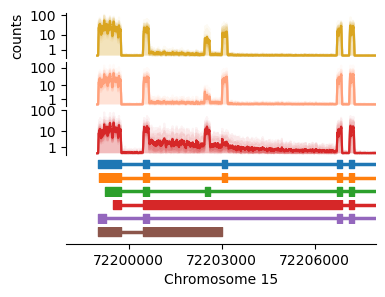

In [139]:
fig, ax = plt.subplots(nrows = 10, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*6 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim1 + 1e4)

plot_counts(counts, ['Brain_Frontal_Cortex_BA9', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['goldenrod', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


yticks = [np.log1p(x) for x in [1, 10, 100]]
ylabels = ['1', '10', '100']


ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
ax[0].set_ylabel('counts')

ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)
# ax[1].set_ylabel('counts')


ax[2].set_yticks(yticks)
ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000067225'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000067225', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_xticks([72200000, 72203000, 72206000, 72230000])
ax[-1].set_xticklabels(['72200000', '72203000', '72206000', '72230000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 15', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/PKM.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PKM.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

In [153]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000100321.csv.gz', index_col=0)

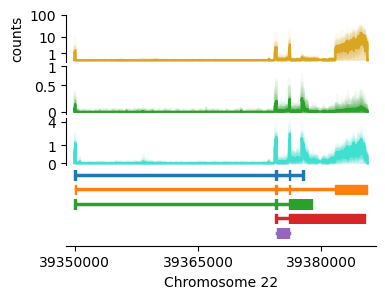

In [155]:
fig, ax = plt.subplots(nrows = 9, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*5 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Brain_Frontal_Cortex_BA9', 'Liver', 'Skin_Not_Sun_Exposed_Suprapubic'] , axes = ax[:3], 
            color_list = ['goldenrod', 'tab:green', 'turquoise'], xlim=xlim, k=20)


yticks = [np.log1p(x) for x in [1, 10, 100]]
ylabels = ['1', '10', '100']


ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
ax[0].set_ylabel('counts')

yticks = [np.log1p(x) for x in [0, 0.5, 1]]
ylabels = ['0', '0.5', '1']

ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)
# ax[1].set_ylabel('counts')

yticks = [np.log1p(x) for x in [0, 1, 4]]
ylabels = ['0', '1', '4']



ax[2].set_yticks(yticks)
ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000100321'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000100321', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_xticks([39350000, 39365000, 39380000])
ax[-1].set_xticklabels(['39350000', '39365000', '39380000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 22', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/SYNGR1.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/SYNGR1.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

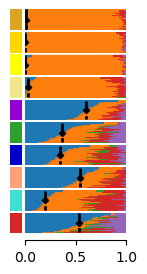

In [151]:
EL_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000100321', sorted_samples].T 
# transcripts_to_plot
# EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000100321.factor_{str(i)}' for i in range(1, 6)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.5, 3),
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure2/SYNGR1.hloadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/SYNGR1.hloadings.png', bbox_inches='tight', dpi=500)

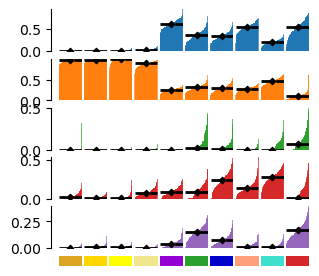

In [152]:
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], 
               tissue_colors = colors_list,
               sort_factor=True)

plt.savefig('../code/scratch_figures/figure2/SYNGR1.loadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/SYNGR1.loadings.png', bbox_inches='tight', dpi=500)

In [160]:
counts = pd.read_csv('../code/coverage/counts_whole_gene/ENSG00000160131.csv.gz', index_col=0)

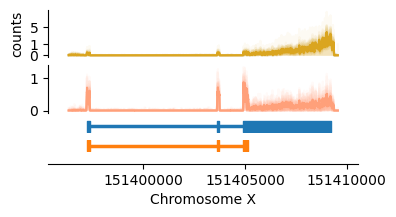

In [161]:
fig, ax = plt.subplots(nrows = 5, figsize=(4, 2), gridspec_kw={'height_ratios': [5]*2 + [1.25]*2 + [0.5], 'hspace': 0.3})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Brain_Frontal_Cortex_BA9', 'Muscle_Skeletal'] , axes = ax[:2], 
            color_list = ['goldenrod', 'lightsalmon'], xlim=xlim, k=20)


yticks = [np.log1p(x) for x in [0, 1, 5]]
ylabels = ['0', '1', '5']


ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
ax[0].set_ylabel('counts')

yticks = [np.log1p(x) for x in [0, 1]]
ylabels = ['0', '1']

ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)
# ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 5]]
ylabels = ['0', '1', '5']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000160131'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000160131', colores = colores,
                         axes=ax[2:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_xticks([151400000, 151405000, 151410000])
ax[-1].set_xticklabels(['151400000', '151405000', '151410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome X', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/VMA21.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/VMA21.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

In [162]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000089220.csv.gz', index_col=0)

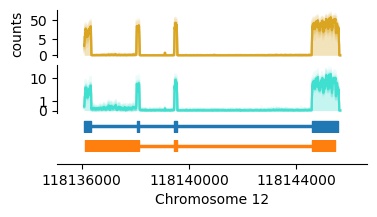

In [163]:
fig, ax = plt.subplots(nrows = 5, figsize=(4, 2), gridspec_kw={'height_ratios': [5]*2 + [1.25]*2 + [0.5], 'hspace': 0.3})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Brain_Frontal_Cortex_BA9', 'Skin_Not_Sun_Exposed_Suprapubic'] , axes = ax[:2], 
            color_list = ['goldenrod', 'turquoise'], xlim=xlim, k=20)


yticks = [np.log1p(x) for x in [0, 5, 50]]
ylabels = ['0', '5', '50']


ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
ax[0].set_ylabel('counts')

yticks = [np.log1p(x) for x in [0, 1, 10]]
ylabels = ['0', '1', '10']

ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)
# ax[1].set_ylabel('counts')




# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000089220'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000089220', colores = colores,
                         axes=ax[2:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_xticks([118136000, 118140000, 118144000])
ax[-1].set_xticklabels(['118136000', '118140000', '118144000'])
# ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 12', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/PEBP1.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PEBP1.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

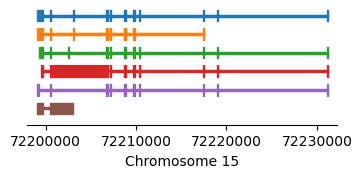

In [4]:
pkm = 'ENSG00000067225'
rds = load_ebpmf_gene(pkm)

fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000067225', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].spines['left'].set_visible(False)
ax[6].set_yticks([])
ax[6].set_xticks([72200000, 72210000, 72220000, 72230000])
ax[6].set_xticklabels(['72200000', '72210000', '72220000', '72230000'])
ax[6].tick_params(labelsize=10)
ax[6].set_xlabel('Chromosome 15', fontsize=10)
ax[6].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.png', bbox_inches='tight', dpi=500)

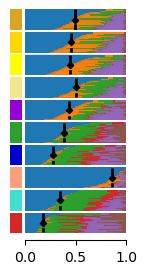

In [147]:
EL_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000067225', sorted_samples].T 
# transcripts_to_plot
# EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000067225.factor_{str(i)}' for i in range(1, 7)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.5, 3),
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure2/PKM.hloadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PKM.hloadings.png', bbox_inches='tight', dpi=500)

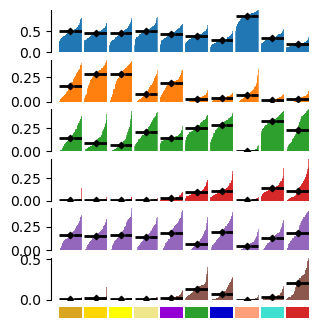

In [148]:
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], 
               tissue_colors = colors_list,
               sort_factor=True)

plt.savefig('../code/scratch_figures/figure2/PKM.loadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PKM.loadings.png', bbox_inches='tight', dpi=500)

2

Text(0.5, 0, 'Chromosome 22')

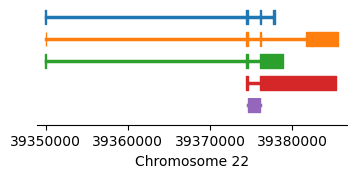

In [22]:
gene = 'ENSG00000100321'
rds = load_ebpmf_gene(gene)

fig, ax = plt.subplots(nrows = 6, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*5 + [0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, gene, colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
ax[5].set_xlim(xlim)
ax[5].set_xticks([39350000, 39360000, 39370000, 39380000])
ax[5].set_xticklabels(['39350000', '39360000', '39370000', '39380000'])
ax[5].tick_params(labelsize=10)
ax[5].set_xlabel('Chromosome 22', fontsize=10)


plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.png', bbox_inches='tight', dpi=500)

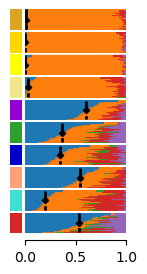

In [23]:
EL_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000100321', sorted_samples].T 
# transcripts_to_plot
# EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000100321.factor_{str(i)}' for i in range(1, 6)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.5, 3),
              tissue_colors = colors_list)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.png', bbox_inches='tight', dpi=500)

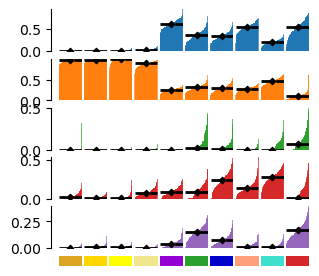

In [24]:
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True,
              tissue_colors = colors_list)

In [7]:
def factor_barplot_v(EL, samples, color_list, label_list, sort_factor = False, figsize=None, ylim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (K/1.2, N/3)
    
    
    

    if one_row:
        fig, axes = plt.subplots(2, N+1, figsize=figsize, gridspec_kw={'hspace': 0.05, 'wspace': 0.1}, 
                             width_ratios = ([1] + ([4]*N)), height_ratios = [10, 1.2])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[0, j+1]

            ax_ = axes[1, j+1]
            ax_.bar([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[1, N-1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            
            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([i, i], [0, loading], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.set_xticks([])
                    ax.spines['left'].set_visible(False)
                    ax.set_yticks([])
                    # axes[j,0].set_ylabel(factor)

                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([i, i], [cum_sum, top_bar], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([len(loadings), 0], [median, median], linestyle = '--', c='black', linewidth=2)
            ax.scatter([middle_point],[median],  marker="D",c ='black', s=10, zorder=len(loadings)+2)

            axes[0, 0].spines['top'].set_visible(False)
            axes[0, 0].spines['right'].set_visible(False)
            axes[0, 0].spines['bottom'].set_visible(False)
            axes[0, 0].set_xticks([])
            axes[0, 0].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if ylim is None:
                axes[0, 0].set_ylim([0,1])

                ax.set_ylim([0,1])
            else:
            


                    
                axes[0, 0].set_ylim(ylim)
                ax.set_ylim(ylim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[1, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            




Text(0.5, 0, 'Chromosome 15')

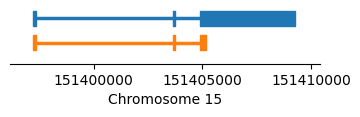

In [25]:
gene = 'ENSG00000160131'
rds = load_ebpmf_gene(gene)

fig, ax = plt.subplots(nrows = 3, figsize=(4, 0.7), gridspec_kw={'height_ratios': [1.5]*2 + [0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, gene, colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_yticks([])
ax[2].set_xlim(xlim)
ax[2].set_xticks([151400000, 151405000, 151410000])
ax[2].set_xticklabels(['151400000', '151405000', '151410000'])
ax[2].tick_params(labelsize=10)
ax[2].set_xlabel('Chromosome 15', fontsize=10)


# plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'Chromosome 15')

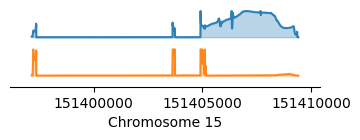

In [48]:
# rds = load_ebpmf_gene('ENSG00000112081')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 3, figsize=(4, 1), gridspec_kw={'height_ratios': [1.5]*2 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000160131', 'ebpmf_10', colores=colores, ax=ax[:2], xlim=xlim, lwidth=1, mute_y_axis=True, lm=False,
                    factor_list = ['factor6', 'factor10'])

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_yticks([])
ax[2].set_xlim(xlim)
ax[2].set_xticks([151400000, 151405000, 151410000])
ax[2].set_xticklabels(['151400000', '151405000', '151410000'])
ax[2].tick_params(labelsize=10)
ax[2].set_xlabel('Chromosome 15', fontsize=10)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_10.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_10.png', bbox_inches='tight', dpi=500)

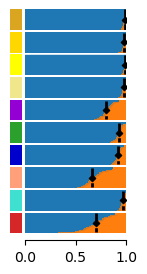

In [169]:
EL_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000160131', sorted_samples].T 
# transcripts_to_plot
# EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000160131.factor_{str(i)}' for i in range(1, 3)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.5, 3),
              tissue_colors = colors_list)
plt.savefig('../code/scratch_figures/figure2/VMA21.hloadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/VMA21.hloadings.png', bbox_inches='tight', dpi=500)

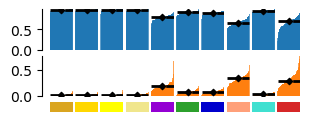

In [170]:

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True,
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure2/VMA21.loadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/VMA21.loadings.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'Chromosome 12')

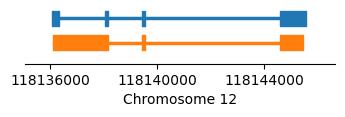

In [49]:
gene = 'ENSG00000089220'
rds = load_ebpmf_gene(gene)

fig, ax = plt.subplots(nrows = 3, figsize=(4, 0.7), gridspec_kw={'height_ratios': [1.5]*2 + [0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, gene, colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_yticks([])
ax[2].set_xlim(xlim)
ax[2].set_xticks([118136000, 118140000, 118144000])
ax[2].set_xticklabels(['118136000', '118140000', '118144000'])
ax[2].tick_params(labelsize=10)
ax[2].set_xlabel('Chromosome 12', fontsize=10)


# plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/PKM.isoforms_10.spacious.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'Chromosome 12')

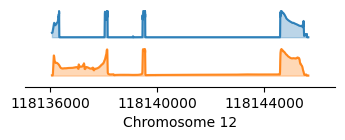

In [63]:
# rds = load_ebpmf_gene('ENSG00000112081')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 3, figsize=(4, 1), gridspec_kw={'height_ratios': [1.5]*2 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000089220', 'ebpmf_10', colores=colores, ax=ax[:2], xlim=xlim, lwidth=1, mute_y_axis=True, lm=False,
                    factor_list = ['factor3', 'factor10'])

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_yticks([])
ax[2].set_xlim(xlim)
ax[2].set_xticks([118136000, 118140000, 118144000])
ax[2].set_xticklabels(['118136000', '118140000', '118144000'])
ax[2].tick_params(labelsize=10)
ax[2].set_xlabel('Chromosome 12', fontsize=10)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_10.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_10.png', bbox_inches='tight', dpi=500)

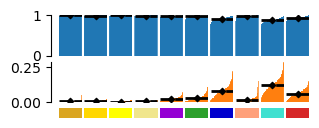

In [167]:
EL_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000089220', sorted_samples].T 
# transcripts_to_plot
# EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000089220.factor_{str(i)}' for i in range(1, 3)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True,
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure2/PEBP1.loadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PEBP1.loadings.png', bbox_inches='tight', dpi=500)

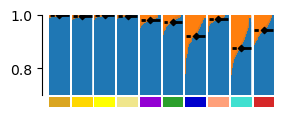

In [13]:
factor_barplot_v(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(3, 1.2),
              tissue_colors = colors_list, ylim=[0.7, 1])

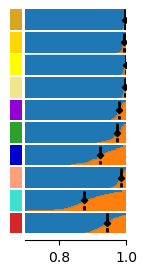

In [168]:
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.5, 3),
              tissue_colors = colors_list, xlim=[0.7, 1])

plt.savefig('../code/scratch_figures/figure2/PEBP1.hloadings.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/PEBP1.hloadings.png', bbox_inches='tight', dpi=500)

In [171]:
colores = np.array(sns.color_palette("tab10"))

annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation = annotation.loc[annotation.appris_transcript_length != 'appris_transcript_length']
annotation['appris_transcript_length'] = annotation.appris_transcript_length.astype(int)
annotation['gene_id'] = [x.split('.')[0] for x in annotation.transcript]
with open('../data/whole_genes.txt', 'r') as fh:
    whole_genes = [x.rstrip() for x in fh.readlines()]

# transcript_KW = pd.read_csv('transcript.KW.tab.gz', sep='\t')
# transcript_EL = pd.read_csv('old_files/transcript.EL.bed.gz', sep='\t')


snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

transcripts = snmf_exons.groupby(['gene_id', 'transcript_id']).factors.first().reset_index()

In [66]:
snmf_exons = snmf_exons.merge(annotation, left_on = ['transcript_id', 'gene_id'], right_on = ['transcript', 'gene_id'])

In [67]:
snmf_exons

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id,transcript,appris_transcript,appris_transcript_length,query_transcript_len,appris_ref,gencode_ref
0,chr1,923874,944151,ENSG00000187634,ENSG00000187634.isoform_1,+,factor_1:factor_3:factor_4:factor_5:factor_6:f...,exon_1,ENSG00000187634.isoform_1,ENST00000616016,14,1,retained.intron,.
1,chr1,924423,924948,ENSG00000187634,ENSG00000187634.isoform_4,+,factor_9,exon_1,ENSG00000187634.isoform_4,ENST00000616016,14,13,utr5/utr3/retained.intron/alt.ss.3,.
2,chr1,924630,924948,ENSG00000187634,ENSG00000187634.isoform_3,+,factor_7,exon_1,ENSG00000187634.isoform_3,ENST00000616016,14,11,utr5/alt.3exon/retained.intron/alt.ss.3,.
3,chr1,925922,926013,ENSG00000187634,ENSG00000187634.isoform_4,+,factor_9,exon_2,ENSG00000187634.isoform_4,ENST00000616016,14,13,utr5/utr3/retained.intron/alt.ss.3,.
4,chr1,925922,926013,ENSG00000187634,ENSG00000187634.isoform_3,+,factor_7,exon_2,ENSG00000187634.isoform_3,ENST00000616016,14,11,utr5/alt.3exon/retained.intron/alt.ss.3,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762778,chrX,156025241,156025422,ENSG00000182484,ENSG00000182484.isoform_6,+,factor_5,exon_5,ENSG00000182484.isoform_6,ENST00000359512,10,5,alt.5exon/utr3/retained.intron/skipped.exon/al...,.
762779,chrX,156025241,156025292,ENSG00000182484,ENSG00000182484.isoform_2,+,factor_10,exon_7,ENSG00000182484.isoform_2,ENST00000359512,10,7,alt.5exon/utr3/alt.ss.2,.
762780,chrX,156025241,156025422,ENSG00000182484,ENSG00000182484.isoform_5,+,factor_4:factor_9,exon_7,ENSG00000182484.isoform_5,ENST00000359512,10,7,alt.5exon/utr3/alt.ss.2,.
762781,chrX,156025241,156025301,ENSG00000182484,ENSG00000182484.isoform_3,+,factor_2,exon_7,ENSG00000182484.isoform_3,ENST00000359512,10,7,utr3/retained.intron/skipped.exon/alt.ss.4,.


In [68]:
with open('../data/whole_genes.txt', 'r') as fh:
    whole_genes = [x.rstrip() for x in fh.readlines()]
    
appris_found = 0
annot_found = 0
alt_found = 0
retained_intron = 0
utr_alt = 0
other_alt = 0
no_alt = 0
appris_ir = 0
whole_gene_ = 0
two_reten = 0

cassette = 0
appris_cassette = 0
two_cassette = 0

for gene, adf in tqdm(annotation.groupby('gene_id'), leave=True, position=0):
    if gene in whole_genes:
        whole_gene_ += 1
        appris_ = False
        if any(adf.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))):
            appris_found += 1
            annot_found += 1
            appris_ = True
        if any(adf.gencode_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))):
            if appris_:
                alt_found += 1
            else:
                annot_found += 1
    
        if any(adf.appris_ref.apply(lambda x: 'retained.intron' in x) & adf.gencode_ref.apply(lambda x: ('intron.chain' not in x) and ('ref.transcript' not in x))):
            retained_intron += 1
            if any(adf.appris_ref.apply(lambda x: 'retained.intron' in x) & ((adf.appris_transcript_length - adf.query_transcript_len)==1)& adf.gencode_ref.apply(lambda x: ('intron.chain' not in x) and ('ref.transcript' not in x))):
                appris_ir += 1
            if any(adf.appris_ref.apply(lambda x: 'retained.intron' in x) & ((adf.appris_transcript_length - adf.query_transcript_len)==2)& adf.gencode_ref.apply(lambda x: ('intron.chain' not in x) and ('ref.transcript' not in x))):
                two_reten += 1
            
    
        if np.sum(adf.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))) >= 2:
            utr_alt += 1

        if any(adf.appris_ref.apply(lambda x: 'cassette' in x)& adf.gencode_ref.apply(lambda x: ('intron.chain' not in x) and ('ref.transcript' not in x))):
            cassette += 1
            if any(adf.appris_ref.apply(lambda x: 'cassette' in x) & ((adf.appris_transcript_length - adf.query_transcript_len)==-1)& adf.gencode_ref.apply(lambda x: ('intron.chain' not in x) and ('ref.transcript' not in x))):
                appris_cassette += 1
            if any(adf.appris_ref.apply(lambda x: 'cassette' in x) & ((adf.appris_transcript_length - adf.query_transcript_len)==-2)& adf.gencode_ref.apply(lambda x: ('intron.chain' not in x) and ('ref.transcript' not in x))):
                two_cassette += 1
        
        if all(adf.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('subset' in x))):
            no_alt += 1

100%|████████████████████████████████████| 15224/15224 [00:16<00:00, 925.34it/s]


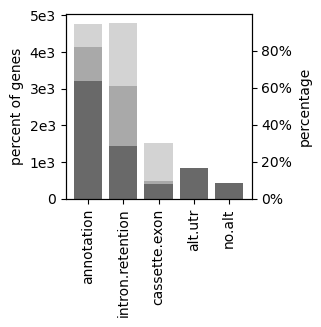

In [69]:
any_annot = annot_found/whole_gene_
appris_and_alt = appris_found/whole_gene_
appris_only = (appris_found/whole_gene_) - (alt_found/whole_gene_)

retained_intron_ = retained_intron/whole_gene_
appris_ir_ = appris_ir/whole_gene_
two_reten_ = (appris_ir/whole_gene_) + (two_reten/whole_gene_)

utr_alt_ = utr_alt/whole_gene_
no_alt_ = no_alt/whole_gene_

cassette_ = cassette/whole_gene_
appris_cassette_ = appris_cassette/whole_gene_
two_cassette_ = (two_cassette/whole_gene_) + appris_cassette_

fig, ax = plt.subplots(figsize=(2.4, 2.4))


ax.bar([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4], [any_annot, appris_and_alt, appris_only, retained_intron_,two_reten_, appris_ir_, 
                                  cassette_, two_cassette_, appris_cassette_,
                                  utr_alt_, no_alt_], 
        color = ['lightgray', 'darkgray', 'dimgray', 'lightgray', 'darkgray', 'dimgray', 'lightgray', 'darkgray', 'dimgray', 'dimgray', 'dimgray'])
ax.set_xticks([0, 1, 2, 3, 4], ['annotation', 'intron.retention', 'cassette.exon', 'alt.utr', 'no.alt'], rotation=90)

ax.set_yticks([0, 1000/whole_gene_, 2000/whole_gene_, 3000/whole_gene_, 4000/whole_gene_, 5000/whole_gene_], ['0', '1e3', '2e3', '3e3', '4e3', '5e3'])

ax.set_ylabel('percent of genes')

ax2 = ax.twinx()
ax2.set_ylabel('percentage')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8], ['0%', '20%', '40%', '60%', '80%'])

In [80]:
annotation.loc[annotation.gene_id.isin(whole_genes)]

,transcript,appris_transcript,appris_transcript_length,query_transcript_len,appris_ref,gencode_ref,gene_id
11,ENSG00000187961.isoform_1,ENST00000338591,12,1,retained.intron,.,ENSG00000187961
12,ENSG00000187961.isoform_2,ENST00000338591,12,9,alt.5exon/retained.intron/alt.ss.2,.,ENSG00000187961
13,ENSG00000187961.isoform_3,ENST00000338591,12,7,alt.5exon/retained.intron,.,ENSG00000187961
14,ENSG00000187961.isoform_4,ENST00000338591,12,5,alt.5exon/retained.intron/alt.ss.5,.,ENSG00000187961
15,ENSG00000187961.isoform_5,ENST00000338591,12,3,alt.5exon/alt.3exon/retained.intron/skipped.exon,.,ENSG00000187961
...,...,...,...,...,...,...,...
86947,ENSG00000155961.isoform_2,ENST00000369454,2,2,intron.chain/utr5,.,ENSG00000155961
86963,ENSG00000124333.isoform_1,ENST00000286448,8,8,alt.ss.1,.,ENSG00000124333
86964,ENSG00000124333.isoform_2,ENST00000286448,8,1,retained.intron,.,ENSG00000124333
86965,ENSG00000124333.isoform_3,ENST00000286448,8,7,alt.5exon/alt.ss.1,.,ENSG00000124333


In [71]:
any_annot

0.7598469143677244

In [72]:
appris_only

0.5134747249242546

In [73]:
appris_and_alt

0.6582682187848828

In [75]:
appris_ir_

0.22835273481103494

In [76]:
two_reten/whole_gene_

0.2635943230744698

In [77]:
cassette

1527

In [19]:
def intron_chain(exons):
    """Generate the intron chain from a list of exons."""
    chain = []
    for i in range(1, len(exons)):
        chain.append((exons[i-1][1], exons[i][0]))
    return chain



In [18]:

def transcript_list_to_dict(transcripts):
    out_dir = {}
    for idx, df in transcripts:
        out_dir.update({idx:df})
    return out_dir


In [20]:
gene_df = snmf_exons.loc[snmf_exons.gene_id == 'ENSG00000112081']

In [24]:
transcripts_dir = transcript_list_to_dict(gene_df.groupby('transcript_id'))


In [26]:
transcripts_dir['ENSG00000112081.isoform_1']

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id,transcript,appris_transcript,appris_transcript_length,query_transcript_len,appris_ref,gencode_ref
661066,chr6,36594379,36594481,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_1,ENSG00000112081.isoform_1,ENST00000373715,6,6,intron.chain/utr3,.
661072,chr6,36596761,36596968,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_2,ENSG00000112081.isoform_1,ENST00000373715,6,6,intron.chain/utr3,.
661077,chr6,36598849,36598983,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_3,ENSG00000112081.isoform_1,ENST00000373715,6,6,intron.chain/utr3,.
661080,chr6,36601152,36601190,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_4,ENSG00000112081.isoform_1,ENST00000373715,6,6,intron.chain/utr3,.
661084,chr6,36601708,36601794,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_5,ENSG00000112081.isoform_1,ENST00000373715,6,6,intron.chain/utr3,.
661093,chr6,36601962,36603379,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_6,ENSG00000112081.isoform_1,ENST00000373715,6,6,intron.chain/utr3,.


In [9]:
transcripts_dir = transcript_list_to_dict(transcripts)
    
    result = {}
    for i, (tid_b, tb) in enumerate(transcripts):
        result[tid_b] = None
        for j, (tid_a, ta) in enumerate(transcripts):
            if (i != j) and is_subset(tb, ta):
                if result[tid_b] is None or (len(ta) > len(transcripts_dir[result[tid_b]])):
                    result[tid_b] = tid_a


transcripts = list(gene_df.groupby('transcript_id'))

0.650454472970818

In [11]:
retained_intron_

0.7480465635464838

In [12]:
any_annot

0.7498006697496412